# SDE Simulation Driven by Fractional Brownian Motion
- We define:
  1. `generate_fbm(T, N, H)` → fBm path
  2. `compute_increments(path)` → ΔB
  3. `simulate_sde_fbm(theta, H, sigma, T, N, X0)` → time grid, X path
  4. `plot_path(times, X, H, sigma)` → visualization


In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
np.float = float
# assume these are provided elsewhere:
# from some_module import fBm, drift


In [2]:
#fBm helper functions

def fBm(T, N, H):
    '''
    Generates sample paths of fractional Brownian Motion using the Davies Harte method
    
    args:
        T:      length of time (in years)
        N:      number of time steps within timeframe
        H:      Hurst parameter
    '''
    gamma = lambda k,H: 0.5*(np.abs(k-1)**(2*H) - 2*np.abs(k)**(2*H) + np.abs(k+1)**(2*H))  
    g = [gamma(k,H) for k in range(0,N)];    r = g + [0] + g[::-1][0:N-1]

    # Step 1 (eigenvalues)
    j = np.arange(0,2*N);   k = 2*N-1
    lk = np.fft.fft(r*np.exp(2*np.pi*complex(0,1)*k*j*(1/(2*N))))[::-1]

    # Step 2 (get random variables)
    Vj = np.zeros((2*N,2), dtype=np.complex128); 
    Vj[0,0] = np.random.standard_normal();  Vj[N,0] = np.random.standard_normal()
    
    for i in range(1,N):
        Vj1 = np.random.standard_normal();    Vj2 = np.random.standard_normal()
        Vj[i][0] = Vj1; Vj[i][1] = Vj2; Vj[2*N-i][0] = Vj1;    Vj[2*N-i][1] = Vj2
    
    # Step 3 (compute Z)
    wk = np.zeros(2*N, dtype=np.complex128)   
    wk[0] = np.sqrt((lk[0]/(2*N)))*Vj[0][0];          
    wk[1:N] = np.sqrt(lk[1:N]/(4*N))*((Vj[1:N].T[0]) + (complex(0,1)*Vj[1:N].T[1]))       
    wk[N] = np.sqrt((lk[0]/(2*N)))*Vj[N][0]       
    wk[N+1:2*N] = np.sqrt(lk[N+1:2*N]/(4*N))*(np.flip(Vj[1:N].T[0]) - (complex(0,1)*np.flip(Vj[1:N].T[1])))
    
    Z = np.fft.fft(wk);     fGn = Z[0:N] 
    fBm = np.cumsum(fGn)*(N**(-H))
    fBm = (T**H)*(fBm)
    path = np.array([0] + list(fBm))
    return path.real


def generate_fbm(T, N, H, MC=1):
    """
    Generate a fractional Brownian motion path of Hurst H on [0, T].
    
    Returns:
        times: np.ndarray of shape (N,)
        B:     np.ndarray of shape (N,)
    """
    times = np.linspace(0, T, N)
    B = np.empty((N+1,MC))
    for i in range(MC):
        B[:,i] = fBm(T, N, H)
    return times, B

def compute_increments(path):
    """
    Compute discrete increments ΔB[k] = path[k+1] - path[k].
    
    Returns:
        increments: np.ndarray of shape (len(path)-1,)
    """
    return np.diff(path)


In [37]:
#Core simulation function
def drift1(theta):
    return lambda x: (theta[0])*((x+1e-8)**(theta[1])) 
def drift2(theta):
    return lambda x: - (x**theta[2])

def simulate_sde_fbm(theta, H, sigma, T, N, X0, MC=1):
    """
    Simulate X_t via Euler scheme:
        dX_t = b_theta(X_t) dt + sigma dB^H_t
    
    Args:
        theta: parameter(s) for the drift
        H:     Hurst exponent of the fBm
        sigma: noise coefficient
        T:     time horizon
        N:     number of discretization points
        X0:    initial condition
        MC: Monte Carlo parameter
    
    Returns:
        times: np.ndarray of shape (N,)
        X:     np.ndarray of shape (N,)
    """
    # Drift function
    b1 = drift1(theta)
    b2 = drift2(theta) 
    
    # Generate fBm and increments
    times, B = generate_fbm(T, N, H, MC)
    dB = np.empty((N,MC))
    for i in range(MC):
        #print(B[:,i].size) (this is just for debugging)
        dB[:,i] = compute_increments(B[:,i])
    #print(dB.size)  #debugging  
    dt = times[1] - times[0]
    
    # Prepare solution array
    X = np.empty((N,MC))
    X[0] = X0
    for k in range(N - 1):
            X[k+1,:] = X[k,:] + b1(X[k,:]) * dt + ( b2(X[k,:]) / ( 1+ dt*np.abs(b2(X[k,:])) ) )*dt +  sigma * dB[k,:] #taming the superlinearity
            #X[k+1,:] = X[k,:] + b1(X[k,:]) * dt + b2(X[k,:])*dt+  sigma * dB[k,:] #simple euler scheme
    
    return times, X, X[N-1]


In [38]:
#Plotting helper

def plot_path(times, X, H=None, sigma=None):
    """
    Plot the simulated path X over times.
    """
    plt.figure(figsize=(8,4))
    plt.plot(times, X, label=r'$X_t$')
    plt.xlabel('Time')
    plt.ylabel('X')
    title = 'SDE Path'
    if H is not None and sigma is not None:
        title += f' (H={H}, σ={sigma})'
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


6.36994425980298


(array([  7.,  29.,  81., 196., 289., 224., 116.,  45.,   8.,   5.]),
 array([1.88257396, 2.33131099, 2.78004802, 3.22878505, 3.67752208,
        4.12625911, 4.57499614, 5.02373317, 5.4724702 , 5.92120723,
        6.36994426]),
 <BarContainer object of 10 artists>)

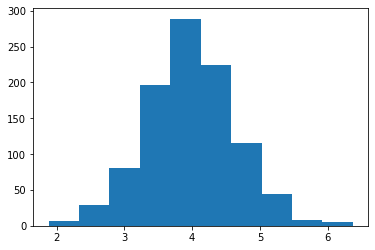

In [41]:
# Example usage

# parameters
theta = np.array([1,-3,1])  # your drift parameter(s)
H     = 0.5
sigma = 1
T     = 1.0
N     = 100
X0    = 0.1
MC    = 1000

# simulate
times, X, X_final = simulate_sde_fbm(theta, H, sigma, T, N, X0, MC)

# visualize
#plot_path(times, X, H, sigma)
print(X_final.max())
plt.hist(X_final)


# density simulation at time T
- We define:
  1.`estimate_density — runs the SDE simulation to simulate the density

In [112]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def inv_sigmoid(x):
    return np.log(x)-np.log(1-x)

In [331]:
from sklearn.neighbors import KernelDensity
def estimate_density(theta, H, sigma, T, N, X0=0 ,MC=1):
    """
    Simulate one path of the SDE and estimate the density at the array x
    Args:
      theta    : parameters for the drift
      H        : Hurst exponent
      sigma    : noise coefficient
      T        : time horizon
      N        : number of points
      X0       : initial value (default 0)
      
    Returns:
      density_est  : float, the estimated f(X_T)
      Y_final : transformed X_T via sigmoid
      X_final-X0 : X_T-X_0
    """
    # 1. simulate the path
    times, X, X_final = simulate_sde_fbm(theta, H, sigma, T, N, X0, MC)
    Y_final = sigmoid(X_final-X0) #for simplicity, i'm always taking the image of the densities by a sigmoid
    #print(X_final) #debugging
    #print(Y_final.max(),Y_final.min())
    Y_final_kde = np.asarray(Y_final)[:, None]
    
    #2. estimate the density with a gaussian kernel
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(Y_final_kde)
    
    sigma_prime = Y_final*(1-Y_final)
    
    density_est = np.exp(kde.score_samples(np.asarray(Y_final)[:, None]))
    
    density_est = density_est * sigma_prime
    
    density_est = np.clip(density_est, 1e-10, np.inf)
    
    return density_est, Y_final, X_final-X0

In [318]:
#Example usage

theta   = np.array([0.1, -1.5,  3])#np.array([1,-3,1])      # your drift parameter(s)
H       = 0.15
sigma   = 1
T       = 1.0      # longer horizon to approximate stationarity
N       = 1000
x       = np.linspace(0, 1, 100) # point of interest
X0      = 0.1
MC      = 1000

density_est, Y_final, X_final_normed = estimate_density(theta, H, sigma, T, N, X0, MC)
#print(f"Estimated density f({x}) = {density_est}")

1.0 0.0


<ipython-input-314-0c523209bafe>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


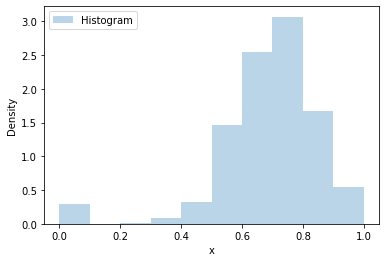

In [305]:
#Example of plot
#plt.plot(x-X0, density_est, label=f'KDE (bw={0.2})')
plt.hist(Y_final, density=True, alpha=0.3, label='Histogram')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

# Target density

In [317]:
#Custom density function

import numpy as np

def custom_density(x, lam, p, q, X0):
    """
    Compute the (unnormalized) density
        f(x) = exp( - (λ/p) * |x|^p  -  (1/q) * |x|^q )
    
    Args:
        x   : float or array-like
        lam : positive float, the λ parameter
        p   : positive float exponent for the first term
        q   : positive float exponent for the second term
    
    Returns:
        float or np.ndarray of same shape as x
    """
    x = np.asarray(x)
    return np.exp( (lam / p) * np.abs(x+X0)**p
                  - (1.0  / q) * np.abs(x+X0)**q)

def log_g(x, lam, p, q, X0):
    """Unnormalized log-density: log g(x)"""
    x = float(x)
    return (lam / p) * np.abs(x + X0)**p - (1.0 / q) * np.abs(x + X0)**q

def metropolis_sampler(log_g, X0, n_samples, step=1.0, burn=1000, args=()):
    """
    Metropolis-Hastings sampler from a 1D log-density.
    
    Args:
        log_g      : function(x, *args) → log density (unnormalized)
        x0         : float, initial point
        n_samples  : number of samples to return (after burn-in)
        step       : proposal std dev (tuning parameter)
        burn       : number of burn-in steps to discard
        args       : extra arguments for log_g (e.g. lam, p, q, X0)

    Returns:
        np.ndarray of shape (n_samples,)
    """
    samples = []
    x = X0
    total = burn + n_samples

    for i in range(total):
        x_prop = x + np.random.normal(0, step)
        log_accept_ratio = log_g(x_prop, *args) - log_g(x, *args)
        if np.log(np.random.rand()) < log_accept_ratio:
            x = x_prop
        if i >= burn:
            samples.append(x)

    return np.array(samples)


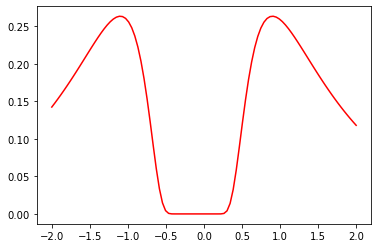

In [332]:
# scalar example
#print(custom_density(0.5, lam=2.0, p=4, q=6))

# vector example
xs = np.linspace(-2, 2, 100)
fs = custom_density(xs, lam=1, p=-3, q=1, X0=0.1)
plt.plot(xs,fs, color='r')

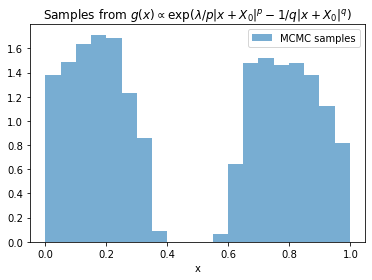

In [338]:
# Parameters
lam = 1.0
p = -3
q = 1
X0 = 0.1

# Run sampler
samples = metropolis_sampler(log_g, X0, n_samples=10000, step=0.5, args=(lam, p, q, X0))

# Plot the result
plt.hist(sigmoid(samples), bins=20, density=True, alpha=0.6, label='MCMC samples')
plt.title("Samples from $g(x) \propto \\exp(\\lambda/p |x+X_0|^p - 1/q |x+X_0|^q)$")
plt.xlabel('x')
plt.legend()
plt.show()

### Objective function

In [350]:
def compute_objective(theta, H, sigma, T, N, lam, p, q, X0, MC):
    """
    Compute the objective
        1/n * Σ_i (density_est(x_i)-custom_density(x_i))**2 / density_est(x_i)
    where:
      - density_est(x_i) is returned by estimate_density(...)

    Args:
        theta     : parameter(s) for the drift
        H         : Hurst exponent
        sigma     : noise coefficient
        T         : time horizon
        N         : number of time-steps
        lam, p, q : parameters of the unnormalized density p(x)
        X0        : initial condition for SDE (default 0)

    Returns:
        float : the computed objective value
    """    
    # estimate_density 
    density_est, y_final, x_final_normed = estimate_density(theta, H, sigma, T, N, X0, MC)
    
    term1 = np.array(density_est)
    #print(term1)
    # 2) Compute custom_density
    term2 = custom_density(x_final_normed, lam, p, q, X0)
    
    integrand = (term1 - term2)**2 / term1
    return np.log(integrand.mean() + 1e-12)

In [351]:
#Example usage
compute_objective(np.array([ 1.5, -2,3]), 0.1, 1, 1, 1000, 1, -3, 1, 0.1, 100)

-3.6951027272172037

# Optimisation procedure

In [261]:
#Run these commands first for pytorch
#conda install nb_conda 
#conda install ipykernel 
#%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113 #download package needeed for optim

In [312]:
import torch
from torch.optim import SGD

## Torch‐wrapped Adam loop

In [340]:
def train_params(
    lam, p, q,
    T, N, MC,      # hyper‐parameters for simulatio,
    X0=0.1,  # for estimate_local_density
    lr=1e-2,
    epochs=200,
    print_every=10
):
    """
    Fit (theta, H) by minimizing the black‐box objective
      compute_objective(theta,H,sigma, T, N, x_points, lam,p,q,X0)
    via a torch‐wrapped Adam loop.
    """
    # 1) initialize torch parameters
    #    - θ : take whatever shape you like; here we assume a 1‐D vector of length d
    d = 3  # << your drift‐param dimensionality >>
    theta = torch.randn(d, requires_grad=True)
    H_raw = torch.randn((), requires_grad=True)      # unconstrained
    #sigma_raw = torch.randn((), requires_grad=True)  # unconstrained

    #optimizer = torch.optim.Adam([theta, H_raw], lr=lr)
    optimizer = SGD([theta, H_raw],
                lr=1e-2, momentum=0.9, nesterov=True)

    for epoch in range(1, epochs+1):
        optimizer.zero_grad()

        # 2) map raw → valid
        H     = torch.sigmoid(H_raw).item()   # in (0,1)
        #sigma = torch.exp(sigma_raw).item()   # >0
        theta_np = theta.detach().cpu().numpy()

        # 4) evaluate black‐box loss
        obj_val = compute_objective(
            theta_np, H, 1,
            T, N,
            lam, p, q, X0=X0,MC=MC
        )
        loss = torch.tensor(obj_val, dtype=torch.float32, requires_grad=True)

        # 5) backward + step  (zero‐order!)
        loss.backward()
        optimizer.step()

        if epoch % print_every == 0:
            print(f"[{epoch:4d}/{epochs}] loss = {obj_val:.6f}")

    # unpack final values
    return {
        "theta": theta.detach().cpu().numpy(),
        "H":     torch.sigmoid(H_raw).item(),
        #"sigma": torch.exp(sigma_raw).item()
    }


In [341]:
#Example usage
T=1
N=100
lam=1
p=-3
q=1
MC=1000
X0=0.1
train_params(lam, p, q,T, N, MC, X0, lr=1e-1,epochs=200,print_every=5)

[   5/200] loss = -4.331078
[  10/200] loss = -4.435843
[  15/200] loss = -4.037437
[  20/200] loss = -3.949590
[  25/200] loss = -4.376924
[  30/200] loss = -4.439238


KeyboardInterrupt: 

## Using Cma.fmin

In [ ]:
#Run these commands first for cma
#pip install cma

In [270]:
import cma

In [342]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def transformation(x):
    return np.array([sigmoid(x[0])*3,sigmoid(x[1])*(-4),1+sigmoid(x[2])*5]) , 0.1+sigmoid(x[3])*0.5

In [ ]:
#Optim with cma
def objective_np(vec):
    theta,H =transformation(vec)      # your unpack‐and‐clip logic
    return compute_objective(theta, H, 1, T, N, lam, p, q, X0, MC)

# initial guess and step‐size
x0 = np.array([0,0,-2, 0])

res = cma.fmin(objective_np, x0, sigma0=1,
               options={'maxiter':20, 'popsize':20})
print("CMA‐ES result:", res[0])
print(transformation(x0))

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 4 (seed=759552, Thu May  8 09:35:30 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     20 -5.627365193188845e+00 1.0e+00 1.51e+00  1e+00  2e+00 0:12.3
    2     40 -2.301590059908729e+01 1.4e+00 2.59e+00  2e+00  3e+00 0:24.8
    3     60 -2.309782631836755e+01 1.8e+00 3.29e+00  3e+00  4e+00 0:36.8
    4     80 -2.301590059908731e+01 1.7e+00 4.40e+00  4e+00  5e+00 0:48.5
    5    100 -2.301590357985635e+01 2.0e+00 4.35e+00  3e+00  5e+00 1:00.7
    6    120 -2.301590059913166e+01 1.6e+00 3.54e+00  2e+00  4e+00 1:12.5
    7    140 -2.340106624349684e+01 2.0e+00 3.28e+00  2e+00  3e+00 1:23.9
    8    160 -2.301593332961305e+01 1.9e+00 3.17e+00  2e+00  3e+00 1:35.2
    9    180 -2.357697695109155e+01 2.1e+00 3.48e+00  2e+00  4e+00 1:47.2
   10    200 -2.301590060082529e+01 2.3e+00 2.78e+00  1e+00  3e+00 1:59.8
   11    220 -2.308619067156852e+01 2.5e+00 2.95e+00  1e+00  3e+00 2:11.7
   12    240 -2.321729

In [345]:
#Checking the found parameters
sol = res[0]
print("lam,p,q=", np.array([sigmoid(sol[0])*3,sigmoid(sol[1])*(-2),1+sigmoid(sol[2])*3]), "H=", 0.1+sigmoid(sol[3])*0.5)

lam,p,q= [ 2.03201514 -1.80196096  1.17975483] H= 0.40336960367326546


# Using scipy.minimize

In [76]:
#Optim with scipy minimize
from scipy.optimize import minimize

res = minimize(objective_np, x0, method='Nelder-Mead',
               options={'maxiter':10, 'disp':True})
print("Nelder‐Mead result:", res.x)

Nelder‐Mead result: [ 2.3437500e-05  3.2421875e-04 -1.9390625e+00 -1.4453125e-04]


In [77]:
sol = res.x
np.array([sigmoid(sol[0])*3,sigmoid(sol[1])*(-2),1+sigmoid(sol[2])*3]), 0.1+sigmoid(sol[3])*0.5

(array([ 1.50001758, -1.00016211,  1.37725266]), 0.34998193359378144)

0.5579146367956936


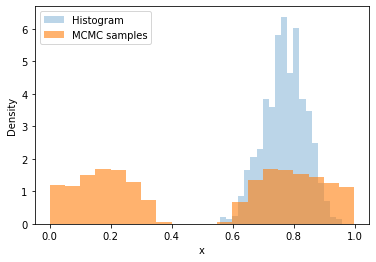

In [347]:
#Looking at the density with the found parameters
lam, p, q= 1, -3, 1
x       = np.linspace(0, 1, 100) 
theta, H = np.array([ 2.03201514, -1.80196096,  1.17975483]), 0.40336960367326546 #plug your parameters here
density_est, Y_final, X_final_normed = estimate_density(theta, H, 1, T, N, X0, MC)
#Example of plot
#print(Y_final.min())
plt.hist(Y_final, bins=20, density=True, alpha=0.3, label='Histogram')
samples = metropolis_sampler(log_g, X0, n_samples=10000, step=0.5, args=(lam, p, q, X0))
plt.hist(sigmoid(samples), bins=20, density=True, alpha=0.6, label='MCMC samples')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()